<a href="https://colab.research.google.com/github/RubinDaija/epfl-ada-2019-project/blob/master/sena_violations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Necessary Imports**

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from scipy import stats
from folium.plugins import MarkerCluster
import warnings
import folium
import zipfile

In [543]:
#-- Uncomment this if using Google Colab / Comment this if using Jupyter Lab --#

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Project_2/food-inspections.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [544]:
#-- Uncomment this if using Jupyter Lab / Comment this if using Google Colab --#
'''
zf = zipfile.ZipFile('chicago_dropped.zip')
df = pd.read_csv(zf.open('chicago_dropped/food_inspections.csv'))
'''

"\nzf = zipfile.ZipFile('chicago_dropped.zip')\ndf = pd.read_csv(zf.open('chicago_dropped/food_inspections.csv'))\n"

# **Data Analysis**

In [0]:
# Plots a histogram with given parameters, i.e. dataframe, number of bins, title, xlabel, and ylabel
def plot_hist(df, bins, title, xlabel, ylabel):
  hist = df.hist(bins=bins)
  hist.set_title(title)
  hist.set_xlabel(xlabel)
  hist.set_ylabel(ylabel)  
  hist.figure

### **Number of Unique Facilities**

In [546]:
df_unique = df.groupby(['Latitude','Longitude','DBA Name']).count()
print("Number of unique facilities: " + str(df_unique.shape[0]))

Number of unique facilities: 27068


### **Facility Type vs. Average Risk**


We analyzed the relationship between the type of facility and the average risk of that facility over all inspections:

In [0]:
# Aggregate data over Facility Type
grouped_fac = df.groupby('Facility Type')

In [548]:
# Compute average risk of each type of facility
grouped_fac_risk_mean = pd.DataFrame(grouped_fac['Risk'].mean()).reset_index()
grouped_fac_risk_mean.head()

,Facility Type,Risk
0,ADULT FAMILY CARE CENTER,1.00000
1,AIRPORT LOUNGE,1.50000
2,ART GALLERY,3.00000
3,ASSISTED LIVING/NURSING HOME,1.00000
4,BAKERY,1.62949


In [549]:
# Compute number of facilities in each type of facility
fac_dist = pd.DataFrame(grouped_fac.count()['Risk']).rename(columns={'Risk':'Counts'}).sort_values(by='Counts',ascending=False).reset_index()
print("Number of different types of facilities :" + str(fac_dist.size))
fac_dist.head(100)

Number of different types of facilities :236


,Facility Type,Counts
0,RESTAURANT,131852
1,RETAIL STORE,25635
2,SCHOOL,12054
3,DAYCARE,9537
4,BAKERY,2923
...,...,...
95,FOOD BOOTH,2
96,VENDING MACHINE,2
97,VFW HALL,2
98,BOYS AND GIRLS CLUB,2


When we plotted the number of facilities in each type of facility vs. their average risk score, we observed no correlation between the two. We observed that the facility type with the highest number of facilities (i.e. restaurant) has a very high average risk score:

### **Facility Type Distribution**

From the bar plot below, we can clearly observe the skewed distribution in Facility Type. Most of our data consists of restaurant, grocery store, and school types of facilities:

<BarContainer object of 15 artists>

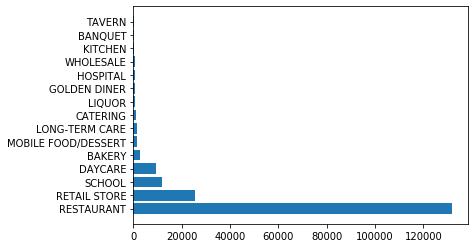

In [550]:
plt.barh(fac_dist.head(15)['Facility Type'],fac_dist.head(15)['Counts'])

### **Number of Facilities in a Type vs. Average Risk Score**

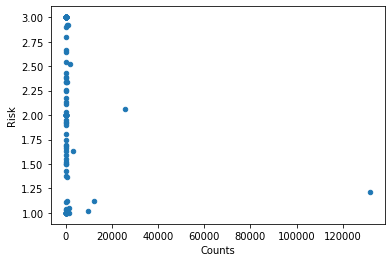

In [551]:
# Perform inner merge on number of facilities and their risk scores 
merged_inner = pd.merge(left=fac_dist,right=grouped_fac_risk_mean,left_on='Facility Type',right_on='Facility Type')
# Scatter plot: number of facilities in each type (i.e. facility type) vs. average risk score
merged_inner.plot.scatter(x='Counts', y='Risk')

We realized that the dataset is unbalanced in terms of number of Facility Types, where there are some Facility Types with very few instances. The types of facilities with very few instances would provide us with little to no information. Hence, we decided to analyze the 50 most frequent type of facilities and drop the others:

In [552]:
print("Number of entries before removing facility types with few instances: " + str(df.size))
df = df[df['Facility Type'].isin(list(fac_dist['Facility Type'])[:50])]
print("Number of entries after removing facility types with few instances: " + str(df.size))

Number of entries before removing facility types with few instances: 3074928
Number of entries after removing facility types with few instances: 3071184


In [553]:
df_oob = df[df.Results.str.contains("Out of Business",na=False)]
df_oob

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Regions
32,2352681,BAR-B-Q TONITE,BAR-B-Q TONITE,2563933.0,RESTAURANT,1,6348 N ARTESIAN AVE,60659.0,2019-12-03T00:00:00.000,CANVASS,Out of Business,NaN,41.997335,-87.691240,"{'latitude': '-87.69123961702296', 'longitude'...",WEST RIDGE
39,2352679,ZAIQA RESTAURANT,ZAIQA RESTAURANT,2632018.0,RESTAURANT,1,2245 W DEVON AVE,60659.0,2019-12-03T00:00:00.000,CANVASS,Out of Business,NaN,41.997674,-87.686756,"{'latitude': '-87.6867563084304', 'longitude':...",WEST RIDGE
49,2352524,TC HOTDOGS,TC HOTDOGS,1954116.0,RESTAURANT,2,1740 N KOSTNER AVE,60639.0,2019-12-02T00:00:00.000,CANVASS,Out of Business,NaN,41.912770,-87.736348,"{'latitude': '-87.7363483567106', 'longitude':...",HUMBOLDT PARK
73,2352554,EAT & DRINK,EAT & DRINK,2069092.0,RESTAURANT,1,4649 N DAMEN AVE,60625.0,2019-12-02T00:00:00.000,CANVASS,Out of Business,NaN,41.966583,-87.678975,"{'latitude': '-87.67897535059605', 'longitude'...",LINCOLN SQUARE
101,2352437,LABRIOL BAKERY AND CAFE,LABRIOLA BAKERY AND CAFE,2374837.0,BAKERY,2,1237 W FULTON MARKET,60607.0,2019-11-27T00:00:00.000,CANVASS,Out of Business,NaN,41.886547,-87.658324,"{'latitude': '-87.6583238753014', 'longitude':...",NEAR WEST SIDE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183766,124467,LAFERIR INTERNET CAFE & GIFT SHOP,"LAFERIR INTERNET CAFE & GIFT SHOP, INC",2021669.0,RESTAURANT,2,4942 N PULASKI RD,60630.0,2010-06-29T00:00:00.000,CANVASS,Out of Business,NaN,41.971339,-87.728265,"{'latitude': '-87.72826479944104', 'longitude'...",ALBANY PARK
184116,251140,SANCHEZ TACOS,SANCHEZ TACOS,1442295.0,RESTAURANT,1,4001 W OGDEN,60623.0,2010-06-22T00:00:00.000,CANVASS,Out of Business,NaN,41.850958,-87.724775,"{'latitude': '-87.72477522322536', 'longitude'...",NORTH LAWNDALE
184358,251054,NEIGHBORHOOD FOOD MART,NEIGHBORHOOD FOOD MART INC,1479700.0,RETAIL STORE,3,2748 W MADISON ST,60612.0,2010-06-17T00:00:00.000,CANVASS,Out of Business,NaN,41.881191,-87.695806,"{'latitude': '-87.69580604798641', 'longitude'...",EAST GARFIELD PARK
184728,112437,SALAD CREATIONS,SALAD CREATIONS,1848010.0,RESTAURANT,2,56 E JACKSON BLVD,60604.0,2010-06-10T00:00:00.000,OUT OF BUSINESS,Out of Business,NaN,41.878367,-87.625582,"{'latitude': '-87.62558159573472', 'longitude'...",LOOP


In [554]:
df_oob['year'] = df_oob['Inspection Date'].apply(lambda x: x.split('-')[0])
df_oob['month'] = df_oob['Inspection Date'].apply(lambda x: x.split('-')[1])
df_oob

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Regions,year,month
32,2352681,BAR-B-Q TONITE,BAR-B-Q TONITE,2563933.0,RESTAURANT,1,6348 N ARTESIAN AVE,60659.0,2019-12-03T00:00:00.000,CANVASS,Out of Business,NaN,41.997335,-87.691240,"{'latitude': '-87.69123961702296', 'longitude'...",WEST RIDGE,2019,12
39,2352679,ZAIQA RESTAURANT,ZAIQA RESTAURANT,2632018.0,RESTAURANT,1,2245 W DEVON AVE,60659.0,2019-12-03T00:00:00.000,CANVASS,Out of Business,NaN,41.997674,-87.686756,"{'latitude': '-87.6867563084304', 'longitude':...",WEST RIDGE,2019,12
49,2352524,TC HOTDOGS,TC HOTDOGS,1954116.0,RESTAURANT,2,1740 N KOSTNER AVE,60639.0,2019-12-02T00:00:00.000,CANVASS,Out of Business,NaN,41.912770,-87.736348,"{'latitude': '-87.7363483567106', 'longitude':...",HUMBOLDT PARK,2019,12
73,2352554,EAT & DRINK,EAT & DRINK,2069092.0,RESTAURANT,1,4649 N DAMEN AVE,60625.0,2019-12-02T00:00:00.000,CANVASS,Out of Business,NaN,41.966583,-87.678975,"{'latitude': '-87.67897535059605', 'longitude'...",LINCOLN SQUARE,2019,12
101,2352437,LABRIOL BAKERY AND CAFE,LABRIOLA BAKERY AND CAFE,2374837.0,BAKERY,2,1237 W FULTON MARKET,60607.0,2019-11-27T00:00:00.000,CANVASS,Out of Business,NaN,41.886547,-87.658324,"{'latitude': '-87.6583238753014', 'longitude':...",NEAR WEST SIDE,2019,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183766,124467,LAFERIR INTERNET CAFE & GIFT SHOP,"LAFERIR INTERNET CAFE & GIFT SHOP, INC",2021669.0,RESTAURANT,2,4942 N PULASKI RD,60630.0,2010-06-29T00:00:00.000,CANVASS,Out of Business,NaN,41.971339,-87.728265,"{'latitude': '-87.72826479944104', 'longitude'...",ALBANY PARK,2010,06
184116,251140,SANCHEZ TACOS,SANCHEZ TACOS,1442295.0,RESTAURANT,1,4001 W OGDEN,60623.0,2010-06-22T00:00:00.000,CANVASS,Out of Business,NaN,41.850958,-87.724775,"{'latitude': '-87.72477522322536', 'longitude'...",NORTH LAWNDALE,2010,06
184358,251054,NEIGHBORHOOD FOOD MART,NEIGHBORHOOD FOOD MART INC,1479700.0,RETAIL STORE,3,2748 W MADISON ST,60612.0,2010-06-17T00:00:00.000,CANVASS,Out of Business,NaN,41.881191,-87.695806,"{'latitude': '-87.69580604798641', 'longitude'...",EAST GARFIELD PARK,2010,06
184728,112437,SALAD CREATIONS,SALAD CREATIONS,1848010.0,RESTAURANT,2,56 E JACKSON BLVD,60604.0,2010-06-10T00:00:00.000,OUT OF BUSINESS,Out of Business,NaN,41.878367,-87.625582,"{'latitude': '-87.62558159573472', 'longitude'...",LOOP,2010,06


In [0]:
df_year = df_oob.groupby("year").count()['Results'].reset_index().rename(columns={'Results':'Count'})

<BarContainer object of 10 artists>

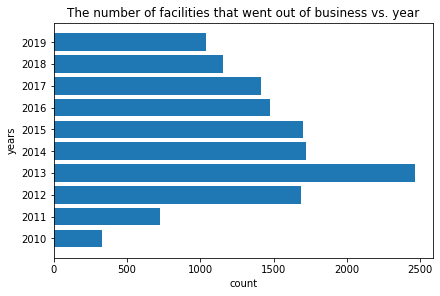

In [556]:
fig, axs = plt.subplots(1, 1, constrained_layout=True)
axs.set_title('The number of facilities that went out of business vs. year')
axs.set_xlabel('count')
axs.set_ylabel('years')
axs.barh(df_year['year'],df_year['Count'])

In the plot above, we can see that year 2013 is the year where the number of closed down facilities peaks. Therefore, we wil analyse the year 2013.

In [0]:
df_oob2013 = df_oob[df_oob.year.str.contains("2013",na=False)]
df_oob_not2013 = df_oob[~df_oob.year.str.contains("2013",na=False)]

In [558]:
df_oob2013.groupby("Regions").count().rename(columns={'Results':'Counts'}).sort_values(by='Counts',ascending=False)['Counts'].reset_index().head(15)

,Regions,Counts
0,LAKE VIEW,173
1,LOOP,159
2,NEAR NORTH SIDE,124
3,LINCOLN PARK,117
4,NEAR SOUTH SIDE,114
5,WEST TOWN,97
6,NEAR WEST SIDE,91
7,LOGAN SQUARE,77
8,AUSTIN,74
9,WEST RIDGE,59


As we can see from the code above, there are around 20 thousand facilities that dont have as much inspections as the others. As a result, data set is more balanced now

In [559]:
df_oob_not2013.groupby("Regions").count().rename(columns={'Results':'Counts'}).sort_values(by='Counts',ascending=False)['Counts'].reset_index().head(15)

,Regions,Counts
0,NEAR NORTH SIDE,721
1,LOOP,642
2,LAKE VIEW,615
3,NEAR WEST SIDE,560
4,WEST TOWN,445
5,AUSTIN,399
6,LINCOLN PARK,383
7,LOGAN SQUARE,353
8,WEST RIDGE,292
9,ALBANY PARK,281


In [560]:
df_month_year = df_oob.groupby(["year","month"]).count()['Results'].reset_index().rename(columns={'Results':'Count'})
df_month_year.sort_values(by='Count', ascending = False).head(10)

,year,month,Count
40,2013,09,369
41,2013,10,354
42,2013,11,301
39,2013,08,235
64,2015,09,232
67,2015,12,229
52,2014,09,222
55,2014,12,213
76,2016,09,212
66,2015,11,201


In [561]:
df_month = df_oob.groupby(["month"]).count()['Results'].reset_index().rename(columns={'Results':'Count'})
df_month.head(12)

,month,Count
0,01,894
1,02,801
2,03,857
3,04,921
4,05,1189
5,06,1051
6,07,1007
7,08,1273
8,09,1625
9,10,1485


<BarContainer object of 12 artists>

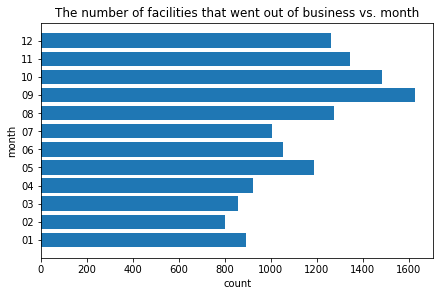

In [562]:
fig, axs = plt.subplots(1, 1, constrained_layout=True)
axs.set_title('The number of facilities that went out of business vs. month')
axs.set_xlabel('count')
axs.set_ylabel('month')
axs.barh(df_month['month'],df_month['Count'])

### **Out of Business Facilities on Map**

In [563]:
# Out of business facilities
df_oob = df[df.Results.str.contains("Out of Business",na=False)]
df_oob
# Grouped by the facilities
df_oob_unique = df_oob.groupby(['Latitude','Longitude','DBA Name', 'License #']).count()
df_oob_unique.shape

(13287, 12)

We mapped the facilities that have gone out of business to identify any possible pattern:

In [564]:
'''
# Map the facilities that have gone out of business 
map_oob = folium.Map(
    location=[41.8781, -87.6298],
    zoom_start=9
)

# We take 5000 samples to view on the map
# TODO: take randomized samples / visualize the whole data
marker_cluster = MarkerCluster().add_to(map_oob)
ranges = 0
for i in df_oob_unique.index:
    if ranges == 5000:
        break
    folium.Marker([(i[0]), (i[1])]).add_to(marker_cluster)        
    ranges = ranges + 1

map_oob
'''

'\n# Map the facilities that have gone out of business \nmap_oob = folium.Map(\n    location=[41.8781, -87.6298],\n    zoom_start=9\n)\n\n# We take 5000 samples to view on the map\n# TODO: take randomized samples / visualize the whole data\nmarker_cluster = MarkerCluster().add_to(map_oob)\nranges = 0\nfor i in df_oob_unique.index:\n    if ranges == 5000:\n        break\n    folium.Marker([(i[0]), (i[1])]).add_to(marker_cluster)        \n    ranges = ranges + 1\n\nmap_oob\n'

### **Average Risk of Facilities on Map**

In [0]:
# Calculate risk mean of each facility
df_avg_risk_score = df.groupby(['Latitude','Longitude','DBA Name'])['Risk'].mean()

We mapped the average risk score of facilities to identify any possible pattern:

In [566]:
# Map the average risk score of facilities, where red indicates high risk, orange indicates medium risk, and green indicates low risk
'''
map_risk = folium.Map(
    location=[41.8781, -87.6298],
    zoom_start=9
)

# We take 2000 samples to view on the map
# TODO: take randomized samples / visualize the whole data
ranges = 0
for i in df_avg_risk_score.index:
    if ranges == 2000:
        break
    if(round(df_avg_risk_score[i]) == 1):
        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='red')).add_to(map_risk)
    elif(round(df_avg_risk_score[i]) == 2):
        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='orange')).add_to(map_risk)
    elif(round(df_avg_risk_score[i]) == 3):
        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='green')).add_to(map_risk)       
    ranges = ranges + 1

map_risk
'''

"\nmap_risk = folium.Map(\n    location=[41.8781, -87.6298],\n    zoom_start=9\n)\n\n# We take 2000 samples to view on the map\n# TODO: take randomized samples / visualize the whole data\nranges = 0\nfor i in df_avg_risk_score.index:\n    if ranges == 2000:\n        break\n    if(round(df_avg_risk_score[i]) == 1):\n        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='red')).add_to(map_risk)\n    elif(round(df_avg_risk_score[i]) == 2):\n        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='orange')).add_to(map_risk)\n    elif(round(df_avg_risk_score[i]) == 3):\n        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='green')).add_to(map_risk)       \n    ranges = ranges + 1\n\nmap_risk\n"

We plotted the number of inspections vs. the average risk score of each facility to identify any possible correlation between the two. We observed the there is a negative correlation between the number of inspections and the average risk of the facility:

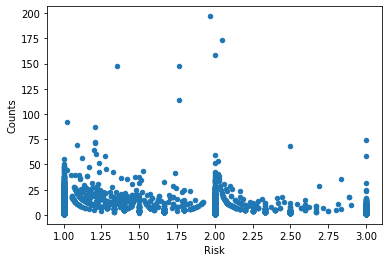

In [567]:
# Scatter plot on the number of inspections vs. the average risk score
df_unique = pd.DataFrame(df.groupby(['Latitude','Longitude','DBA Name']).count()['Risk']).rename(columns={'Risk':'Counts'})
merged = pd.merge(left=df_avg_risk_score.reset_index(),right=df_unique.reset_index(),left_on=['Latitude','Longitude','DBA Name'],right_on=['Latitude','Longitude','DBA Name'])
merged.plot.scatter(x='Risk', y='Counts')

We observed that the number of risk 3 facilities are lower than the others. Hence, we decided to plot average risk scores vs number of facilities.

### **Correlation between Number of Inspections and Average Level of Risk**

We observed a moderate positive correlation between the number of inspections and average level of risk of the facility (since Risk 1 means high risk and Risk 3 means low risk):

In [568]:
merged[['Risk', 'Counts']].corr(method='pearson')

,Risk,Counts
Risk,1.000000,-0.365569
Counts,-0.365569,1.000000


### **Distribution of Risk Scores of Facilities**

We visualized the distribution of average level of risk scores of each facility using the bar plot below:

In [569]:
# Grouped by risk scores and number of facilities
df_avg_risk_score1 = pd.DataFrame(df_avg_risk_score).apply(lambda x: round(x)).reset_index()
df_avg_risk_score1 = pd.DataFrame(df_avg_risk_score1.groupby('Risk').count()['Latitude']).rename(columns={'Latitude':'Counts'})
df_avg_risk_score1

,Counts
Risk,
1.0,15581
2.0,6720
3.0,4688


<BarContainer object of 3 artists>

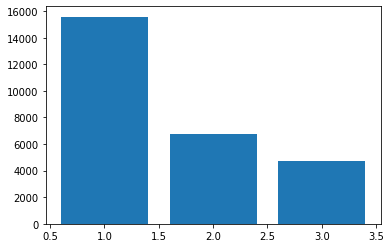

In [570]:
plt.bar(df_avg_risk_score1.index,df_avg_risk_score1['Counts'])

### **Different Branches vs. Risk Score**

For the next milestone, we want to analyze the average risk score of a facility between its different branches.

In [0]:
# Identify the facility with the highest number of branches
#grouped_name = df.groupby('DBA Name').count()
grouped_unique_name = pd.DataFrame(df.groupby('DBA Name').count().rename(columns={'Risk':'Counts'})['Counts']).sort_values(by='Counts',ascending=False).reset_index()
grouped_unique_facility = pd.DataFrame(df.groupby(['Latitude','Longitude','DBA Name']).count().rename(columns={'Risk':'Counts'})['Counts']).sort_values(by='Counts',ascending=False).reset_index()

We will be investigating the facility (chain) with the highest number of branches to see if there is any difference in the risk scores of its branches. 

In [572]:
# The facilities with the highest number of inspections (chain)
grouped_unique_name.head()

,DBA Name,Counts
0,SUBWAY,4069
1,DUNKIN DONUTS,2259
2,MCDONALDS,2216
3,7-ELEVEN,1410
4,STARBUCKS,1398


In [573]:
# The facilities with the highest number of inspections (unique)
grouped_unique_facility.head()

,Latitude,Longitude,DBA Name,Counts
0,41.862628,-87.615031,SPORT SERVICE SOLDIER FIELD,197
1,41.830784,-87.635296,ILLINOIS SPORTSERVICE,173
2,42.008536,-87.914428,STARBUCKS,159
3,42.008536,-87.914428,MCDONALDS,148
4,41.947317,-87.656418,LEVY RESTAURANTS,148


### **Type of Facility vs. Percentage of Going Out of Business**

In [574]:
# Data grouped by the facility type
fac_dist.head()

,Facility Type,Counts
0,RESTAURANT,131852
1,RETAIL STORE,25635
2,SCHOOL,12054
3,DAYCARE,9537
4,BAKERY,2923


In [0]:
# Group out of business facilities on facility type
df_oob_fac = pd.DataFrame(df_oob.groupby('Facility Type').count().rename(columns={'Risk':'Counts'})['Counts'])
merged_fac_oob = pd.merge(left=df_oob_fac.reset_index(), right=fac_dist.reset_index(),left_on=['Facility Type'],right_on=['Facility Type'])

In [576]:
merged_fac_oob.head()

,Facility Type,Counts_x,index,Counts_y
0,ASSISTED LIVING/NURSING HOME,4,21,95
1,BAKERY,249,4,2923
2,BANQUET,19,13,338
3,BAR,6,24,81
4,BUTCHER,5,34,34


In [0]:
merged_fac_oob['Oob Ratio'] = merged_fac_oob['Counts_x'].divide(merged_fac_oob['Counts_y'], fill_value=1)

In [578]:
merged_fac_oob.sort_values(by='Oob Ratio', ascending=False).drop(columns='index').head()

,Facility Type,Counts_x,Counts_y,Oob Ratio
30,PANTRY,5,9,0.555556
14,DISTRIBUTION,3,10,0.300000
41,WAREHOUSE,2,13,0.153846
4,BUTCHER,5,34,0.147059
18,HERBAL,6,47,0.127660


In [579]:
merged_fac_oob[['Oob Ratio', 'Counts_y']].corr(method='pearson')

,Oob Ratio,Counts_y
Oob Ratio,1.000000,-0.042375
Counts_y,-0.042375,1.000000


We wanted to identify a possible correlation between the type of facility and the percentage of going out of business. However, when we calculated the pearson's correlation factor, we observed no correlation.

### **Percentage of Going Out of Business vs. Average Risk Score**

In [0]:
# Merge the out of business facility types with their average risk scores
fac_oob_risk = pd.merge(left=merged_fac_oob.reset_index(), right=grouped_fac_risk_mean.reset_index(),left_on=['Facility Type'],right_on=['Facility Type'])

In [581]:
fac_oob_risk.drop(columns=['index_x', 'index_y']).rename(columns={'Counts_x':'Oob Count', 'Counts_y':'Total Count'}).head()

,level_0,Facility Type,Oob Count,Total Count,Oob Ratio,Risk
0,0,ASSISTED LIVING/NURSING HOME,4,95,0.042105,1.000000
1,1,BAKERY,249,2923,0.085186,1.629490
2,2,BANQUET,19,338,0.056213,1.118343
3,3,BAR,6,81,0.074074,2.135802
4,4,BUTCHER,5,34,0.147059,2.029412


In [582]:
fac_oob_risk[['Oob Ratio', 'Risk']].corr(method='pearson')

,Oob Ratio,Risk
Oob Ratio,1.000000,0.202511
Risk,0.202511,1.000000


We wanted to identify a possible correlation between the out of business ratio and the risk of the type of facility. However, when we calculated the pearson's correlation factor, we observed no correlation.



## **Violation Type Analysis**

### **Violations analysis - facilities that have gone out of business**

In [583]:
df_oob_unique.reset_index(inplace=True)
merged_oob = pd.merge(left=df_oob_unique[['Latitude', 'Longitude', 'DBA Name']], right=df, on=['Latitude', 'Longitude', 'DBA Name'])
merged_oob.head(10)

,Latitude,Longitude,DBA Name,Inspection ID,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Location,Regions
0,41.64467,-87.540095,BURGER KING,2240219,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-11-15T00:00:00.000,COMPLAINT,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
1,41.64467,-87.540095,BURGER KING,2200946,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-08-14T00:00:00.000,COMPLAINT,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
2,41.64467,-87.540095,BURGER KING,1950282,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2016-08-12T00:00:00.000,CANVASS,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...","{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
3,41.64467,-87.540095,BURGER KING,1523175,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2015-02-23T00:00:00.000,LICENSE,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
4,41.64467,-87.540095,BURGER KING,1527281,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2015-02-23T00:00:00.000,CANVASS,Out of Business,NaN,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
5,41.64467,-87.540095,BURGER KING,1494060,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2014-08-26T00:00:00.000,CANVASS,Pass,NaN,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
6,41.64467,-87.540095,BURGER KING,1493718,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2014-08-18T00:00:00.000,CANVASS,Fail,12. HAND WASHING FACILITIES: WITH SOAP AND SAN...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
7,41.64467,-87.540095,BURGER KING,1300984,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2012-12-19T00:00:00.000,CANVASS,Pass w/ Conditions,21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
8,41.64467,-87.540095,BURGER KING,537818,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2012-01-10T00:00:00.000,COMPLAINT,Pass w/ Conditions,8. SANITIZING RINSE FOR EQUIPMENT AND UTENSILS...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
9,41.64467,-87.540095,BURGER KING,537384,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2011-05-26T00:00:00.000,COMPLAINT,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH


In [584]:
# Out of business facilities that have more than 1 inspection
dup_oob = merged_oob.groupby(['Latitude', 'Longitude', 'DBA Name']).filter(lambda x : len(x) > 1)
dup_oob.head(10)

,Latitude,Longitude,DBA Name,Inspection ID,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Location,Regions
0,41.64467,-87.540095,BURGER KING,2240219,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-11-15T00:00:00.000,COMPLAINT,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
1,41.64467,-87.540095,BURGER KING,2200946,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-08-14T00:00:00.000,COMPLAINT,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
2,41.64467,-87.540095,BURGER KING,1950282,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2016-08-12T00:00:00.000,CANVASS,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...","{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
3,41.64467,-87.540095,BURGER KING,1523175,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2015-02-23T00:00:00.000,LICENSE,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
4,41.64467,-87.540095,BURGER KING,1527281,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2015-02-23T00:00:00.000,CANVASS,Out of Business,NaN,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
5,41.64467,-87.540095,BURGER KING,1494060,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2014-08-26T00:00:00.000,CANVASS,Pass,NaN,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
6,41.64467,-87.540095,BURGER KING,1493718,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2014-08-18T00:00:00.000,CANVASS,Fail,12. HAND WASHING FACILITIES: WITH SOAP AND SAN...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
7,41.64467,-87.540095,BURGER KING,1300984,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2012-12-19T00:00:00.000,CANVASS,Pass w/ Conditions,21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
8,41.64467,-87.540095,BURGER KING,537818,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2012-01-10T00:00:00.000,COMPLAINT,Pass w/ Conditions,8. SANITIZING RINSE FOR EQUIPMENT AND UTENSILS...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
9,41.64467,-87.540095,BURGER KING,537384,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2011-05-26T00:00:00.000,COMPLAINT,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH


In [585]:
dup_oob.dropna(subset=['Violations'], inplace=True) # the inspections that have violations (out of business facilities)
dup_oob.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Latitude,Longitude,DBA Name,Inspection ID,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Location,Regions
0,41.644670,-87.540095,BURGER KING,2240219,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-11-15T00:00:00.000,COMPLAINT,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
1,41.644670,-87.540095,BURGER KING,2200946,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-08-14T00:00:00.000,COMPLAINT,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
2,41.644670,-87.540095,BURGER KING,1950282,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2016-08-12T00:00:00.000,CANVASS,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...","{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
3,41.644670,-87.540095,BURGER KING,1523175,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2015-02-23T00:00:00.000,LICENSE,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
6,41.644670,-87.540095,BURGER KING,1493718,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2014-08-18T00:00:00.000,CANVASS,Fail,12. HAND WASHING FACILITIES: WITH SOAP AND SAN...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
7,41.644670,-87.540095,BURGER KING,1300984,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2012-12-19T00:00:00.000,CANVASS,Pass w/ Conditions,21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
8,41.644670,-87.540095,BURGER KING,537818,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2012-01-10T00:00:00.000,COMPLAINT,Pass w/ Conditions,8. SANITIZING RINSE FOR EQUIPMENT AND UTENSILS...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
9,41.644670,-87.540095,BURGER KING,537384,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2011-05-26T00:00:00.000,COMPLAINT,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
10,41.644670,-87.540095,BURGER KING,419402,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2010-10-12T00:00:00.000,COMPLAINT,Pass w/ Conditions,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
14,41.646371,-87.560342,WINJAMMER MARINA,1395212,WINJAMMER MARINA,79113.0,RESTAURANT,2,13701 S HOXIE AVE,60633.0,2013-12-30T00:00:00.000,CANVASS,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,"{'latitude': '-87.56034196262158', 'longitude'...",HEGEWISCH


In [586]:
violations_oob = dup_oob['Violations'].apply(lambda x: re.findall(r'^[0-9]+[.] | [|] [0-9]+[.] ', x))
violations_oob = pd.DataFrame(violations_oob)
violation_nums_oob = violations_oob['Violations'].apply(lambda x: [int(sub.replace('|','').split('.')[0]) for sub in x])
violation_nums_oob

0                        [2, 3, 5]
1                [2, 3, 5, 49, 55]
2                     [34, 35, 38]
3                     [33, 34, 45]
6         [12, 21, 28, 29, 33, 38]
                    ...           
100332                [32, 33, 34]
100333                        [41]
100334                [18, 28, 41]
100335                    [21, 33]
100336                [18, 21, 33]
Name: Violations, Length: 65918, dtype: object

In [587]:
violation_nums_oob = pd.DataFrame(violation_nums_oob)
violation_nums_oob.reset_index(inplace=True)
violation_nums_oob.drop(columns='index', inplace=True)
violation_nums_oob.head(10)

,Violations
0,"[2, 3, 5]"
1,"[2, 3, 5, 49, 55]"
2,"[34, 35, 38]"
3,"[33, 34, 45]"
4,"[12, 21, 28, 29, 33, 38]"
5,"[21, 33, 34, 35, 38, 40, 41, 42]"
6,"[8, 21, 33, 34, 35, 36, 38]"
7,"[33, 34, 35, 36, 38]"
8,"[3, 12, 21, 33, 34]"
9,"[33, 34, 35]"


In [0]:
vio_freq_oob = {}
for i in violation_nums_oob['Violations']:
  for j in i:
    vio_freq_oob[str(j)] = 1 if str(j) not in vio_freq_oob else vio_freq_oob[str(j)]+1

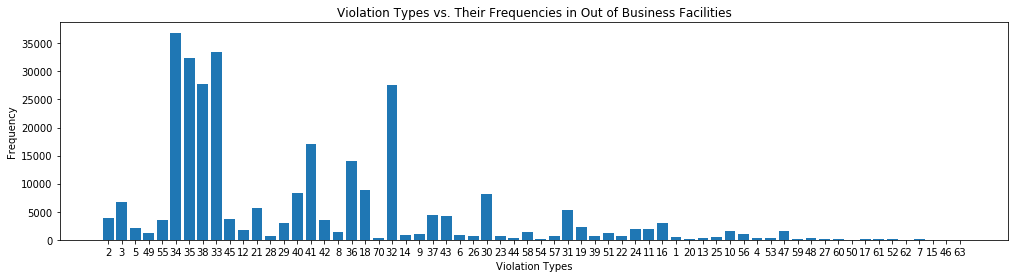

In [589]:
plt.figure(figsize=(17,4))
plt.bar(list(vio_freq_oob.keys()), vio_freq_oob.values())
plt.title('Violation Types vs. Their Frequencies in Out of Business Facilities')
plt.xlabel('Violation Types')
plt.ylabel('Frequency')
plt.show()

From the figure above, we can see that certain violation types outnumber the others. So, we decided to sort the violation types in terms of their frequencies and display them in the graph below.

In [0]:
sorted_vio_freq_oob = {}

for key in sorted(vio_freq_oob, key=vio_freq_oob.__getitem__, reverse=True):
  sorted_vio_freq_oob[key] = vio_freq_oob[key]

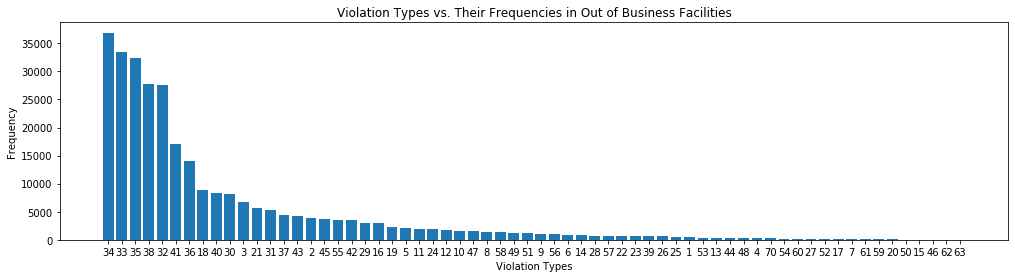

In [591]:
plt.figure(figsize=(17,4))
plt.bar(list(sorted_vio_freq_oob.keys()), sorted_vio_freq_oob.values())
plt.title('Violation Types vs. Their Frequencies in Out of Business Facilities')
plt.xlabel('Violation Types')
plt.ylabel('Frequency')
plt.show()

In [592]:
most_freq_vio_oob = [key for key, value in list(sorted_vio_freq_oob.items())[0:15]]
most_freq_vio_oob # top 10 most frequent violation types among facilities that went out of business

['34',
 '33',
 '35',
 '38',
 '32',
 '41',
 '36',
 '18',
 '40',
 '30',
 '3',
 '21',
 '31',
 '37',
 '43']

In [0]:
# Inspections of facilities that didn't go out of business
# https://stackoverflow.com/questions/18180763/set-difference-for-pandas
 set_diff_oob = pd.concat([df, merged_oob, merged_oob], sort=True).drop_duplicates(keep=False, subset=['Latitude', 'Longitude', 'DBA Name', 'Inspection Date'])

In [594]:
set_diff_oob.dropna(subset=['Violations'], inplace=True) # the inspections that have violations (not out of business facilities)
set_diff_oob.head(10)

,AKA Name,Address,DBA Name,Facility Type,Inspection Date,Inspection ID,Inspection Type,Latitude,License #,Location,Longitude,Regions,Results,Risk,Violations,Zip
1,CHILI'S (T1-B14),11601 W TOUHY AVE,CHILIS T-I,RESTAURANT,2019-12-04T00:00:00.000,2352734,CANVASS,42.008536,34169.0,"{'latitude': '-87.91442843927047', 'longitude'...",-87.914428,OHARE,Pass,1,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,60666.0
2,NaN,3401 W BELMONT AVE,TAQUERIA BLUE LINE,RESTAURANT,2019-12-04T00:00:00.000,2352701,LICENSE,41.939168,2703436.0,"{'latitude': '-87.71254599117191', 'longitude'...",-87.712546,AVONDALE,Pass w/ Conditions,1,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",60618.0
6,NAIBOA LATIN STORE,3349 N CLARK ST,NAIBOA LATIN STORE,RETAIL STORE,2019-12-04T00:00:00.000,2352702,LICENSE,41.943032,2698776.0,"{'latitude': '-87.65299525711882', 'longitude'...",-87.652995,LAKE VIEW,Pass w/ Conditions,3,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,60657.0
7,JAMIESON PUBLIC SCHOOL,5650 N MOZART,JAMIESON,SCHOOL,2019-12-04T00:00:00.000,2352718,CANVASS,41.984614,23931.0,"{'latitude': '-87.70056525028134', 'longitude'...",-87.700565,WEST RIDGE,Pass,1,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Com...,60659.0
9,BLUE LINE,1548 N DAMEN AVE,BLUE LINE,RESTAURANT,2019-12-03T00:00:00.000,2352629,CANVASS,41.909616,1170410.0,"{'latitude': '-87.6775884711046', 'longitude':...",-87.677588,WEST TOWN,Pass w/ Conditions,1,25. CONSUMER ADVISORY PROVIDED FOR RAW/UNDERCO...,60622.0
13,BRIGADOON,5748 W LAWRENCE AVE,BRIGADOON,TAVERN,2019-12-03T00:00:00.000,2352677,COMPLAINT,41.967838,12144.0,"{'latitude': '-87.7716235051089', 'longitude':...",-87.771624,PORTAGE PARK,Pass w/ Conditions,3,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",60630.0
14,HARRY CARAY'S SHORTSTOP,5700 S CICERO AVE,HARRY CARAYS SHORTSTOP,RESTAURANT,2019-12-03T00:00:00.000,2352653,CANVASS,41.789329,2689813.0,"{'latitude': '-87.74164564419637', 'longitude'...",-87.741646,GARFIELD RIDGE,Pass,1,45. SINGLE-USE/SINGLE-SERVICE ARTICLES: PROPER...,60638.0
17,SUBWAY,615 W LAKE ST,SUBWAY,RESTAURANT,2019-12-03T00:00:00.000,2352617,LICENSE,41.885594,2703766.0,"{'latitude': '-87.64346245829006', 'longitude'...",-87.643462,NEAR WEST SIDE,Pass w/ Conditions,1,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",60661.0
19,AMARIT RESTAURANT,600 S DEARBORN ST,AMARIT RESTAURANT,RESTAURANT,2019-12-03T00:00:00.000,2352649,CANVASS,41.874481,1801618.0,"{'latitude': '-87.62935653990546', 'longitude'...",-87.629357,LOOP,Fail,1,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,60605.0
21,SWEET SHOT COOKIES,3211 W ARMITAGE AVE,SWEET SHOT COOKIES,RESTAURANT,2019-12-03T00:00:00.000,2352595,LICENSE,41.917287,2688916.0,"{'latitude': '-87.70745338783728', 'longitude'...",-87.707453,LOGAN SQUARE,Pass,2,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Com...,60647.0


### **Violations analysis - facilities that have not gone out of business**

In [595]:
violations_not_oob = set_diff_oob['Violations'].apply(lambda x: re.findall(r'^[0-9]+[.] | [|] [0-9]+[.] ', x))
violations_not_oob = pd.DataFrame(violations_not_oob)
violation_nums_not_oob = violations_not_oob['Violations'].apply(lambda x: [int(sub.replace('|','').split('.')[0]) for sub in x])
violation_nums_not_oob

1                                 [10, 47, 49, 55, 55]
2                               [3, 5, 16, 51, 53, 58]
6                                      [5, 36, 51, 53]
7                                         [49, 55, 56]
9                                                 [25]
                              ...                     
192162                                            [38]
192171                    [12, 21, 33, 34, 35, 38, 41]
192173                            [32, 33, 35, 38, 40]
192174                            [33, 34, 35, 38, 41]
192180    [18, 19, 32, 33, 34, 35, 36, 37, 38, 39, 41]
Name: Violations, Length: 85369, dtype: object

In [596]:
violation_nums_not_oob = pd.DataFrame(violation_nums_not_oob)
violation_nums_not_oob.reset_index(inplace=True)
violation_nums_not_oob.drop(columns='index', inplace=True)
violation_nums_not_oob.head(10)

,Violations
0,"[10, 47, 49, 55, 55]"
1,"[3, 5, 16, 51, 53, 58]"
2,"[5, 36, 51, 53]"
3,"[49, 55, 56]"
4,[25]
5,"[3, 5, 10, 49, 51, 53, 55, 55]"
6,"[45, 55]"
7,"[3, 5, 57]"
8,"[10, 10, 10, 23, 25, 39, 50, 52, 55, 55, 56]"
9,"[49, 55, 55, 56, 57]"


In [0]:
vio_freq_not_oob = {}
for i in violation_nums_not_oob['Violations']:
  for j in i:
    vio_freq_not_oob[str(j)] = 1 if str(j) not in vio_freq_not_oob else vio_freq_not_oob[str(j)]+1

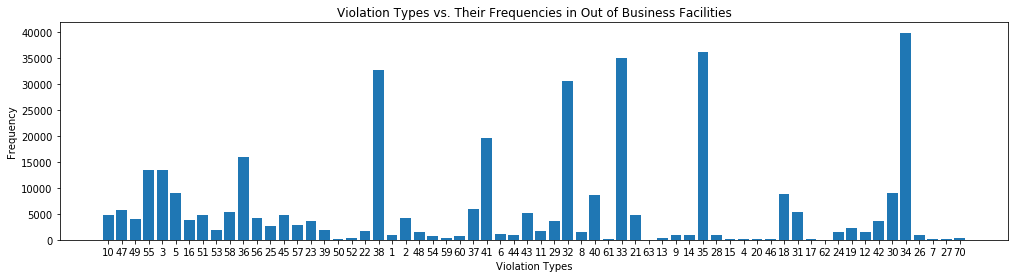

In [598]:
plt.figure(figsize=(17,4))
plt.bar(list(vio_freq_not_oob.keys()), vio_freq_not_oob.values())
plt.title('Violation Types vs. Their Frequencies in Out of Business Facilities')
plt.xlabel('Violation Types')
plt.ylabel('Frequency')
plt.show()

In [0]:
sorted_vio_freq_not_oob = {}

for key in sorted(vio_freq_not_oob, key=vio_freq_not_oob.__getitem__, reverse=True):
  sorted_vio_freq_not_oob[key] = vio_freq_not_oob[key]

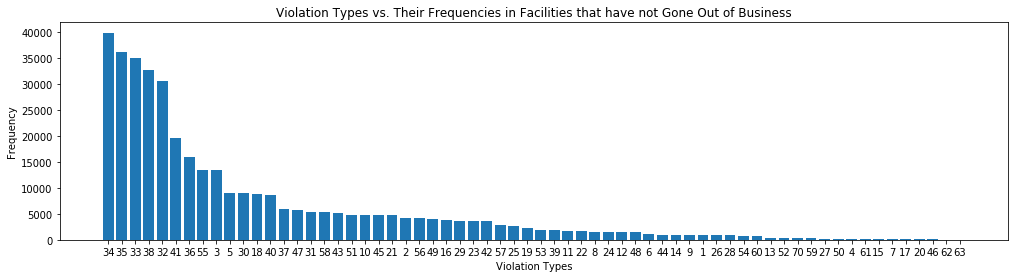

In [600]:
plt.figure(figsize=(17,4))
plt.bar(list(sorted_vio_freq_not_oob.keys()), sorted_vio_freq_not_oob.values())
plt.title('Violation Types vs. Their Frequencies in Facilities that have not Gone Out of Business')
plt.xlabel('Violation Types')
plt.ylabel('Frequency')
plt.show()

In [601]:
most_freq_vio_not_oob = [key for key, value in list(sorted_vio_freq_not_oob.items())[0:15]]
most_freq_vio_not_oob # top 10 most frequent violation types among facilities that went out of business

['34',
 '35',
 '33',
 '38',
 '32',
 '41',
 '36',
 '55',
 '3',
 '5',
 '30',
 '18',
 '40',
 '37',
 '47']

In [602]:
merged_oob.dropna(subset=['Violations'], inplace=True) # the inspections that have violations (out of business facilities)
merged_oob.sort_values(by='AKA Name').head()

,Latitude,Longitude,DBA Name,Inspection ID,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Location,Regions
23119,41.816834,-87.631346,#1 CHINA EXPRESS,467259,"#1 CHINA EXPRESS , LTD",1869616.0,RESTAURANT,1,4248 S WENTWORTH AVE,60609.0,2010-11-29T00:00:00.000,CANVASS,Pass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...","{'latitude': '-87.6313462733625', 'longitude':...",FULLER PARK
5308,41.735578,-87.670781,#1 CHOP SUEY,277047,#1 CHOP SUEY,2042372.0,RESTAURANT,1,1907 W 87TH ST,60620.0,2010-07-01T00:00:00.000,LICENSE,Fail,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,"{'latitude': '-87.67078075079954', 'longitude'...",AUBURN GRESHAM
5307,41.735578,-87.670781,#1 CHOP SUEY,277104,#1 CHOP SUEY,2042372.0,RESTAURANT,1,1907 W 87TH ST,60620.0,2010-07-06T00:00:00.000,LICENSE,Fail,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...","{'latitude': '-87.67078075079954', 'longitude'...",AUBURN GRESHAM
5305,41.735578,-87.670781,#1 CHOP SUEY,490946,#1 CHOP SUEY,2042372.0,RESTAURANT,1,1907 W 87TH ST,60620.0,2011-01-05T00:00:00.000,COMPLAINT,Pass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...","{'latitude': '-87.67078075079954', 'longitude'...",AUBURN GRESHAM
5304,41.735578,-87.670781,#1 CHOP SUEY,1072233,#1 CHOP SUEY,2042372.0,RESTAURANT,1,1907 W 87TH ST,60620.0,2013-01-08T00:00:00.000,CANVASS,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,"{'latitude': '-87.67078075079954', 'longitude'...",AUBURN GRESHAM


Our aim was to detect any violation type that could result into the facilities going out of business. From our data analysis, we found that most violation types are common between those that went out of business and those that have not. Only Violation Types 21, 31, and 43 are more prevalent in facilities that have gone out of business, but are not so prevalent in those that have not gone out of business.

### **Distribution of number of violations committed in each inspection (in facilities that went out of business)**

In [0]:
num_vio_oob = []
for i in violation_nums_oob['Violations']:
  num_vio_oob.append(len(i))

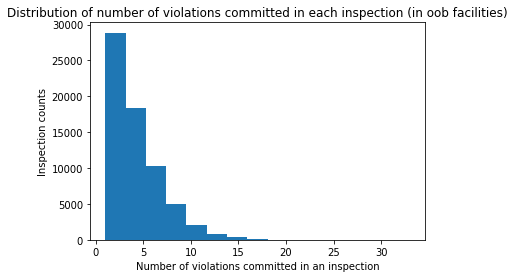

In [604]:
plt.hist(num_vio_oob, bins=15)
plt.title('Distribution of number of violations committed in each inspection (in oob facilities)')
plt.xlabel('Number of violations committed in an inspection')
plt.ylabel('Inspection counts')
plt.show()

In [605]:
print('Average number of violations committed in each inspection (OOB): ' + str(np.mean(num_vio_oob)))
print('Median number of violations committed in each inspection (OOB): ' + str(np.median(num_vio_oob)))

Average number of violations committed in each inspection (OOB): 4.428259352528899
Median number of violations committed in each inspection (OOB): 4.0


### **Distribution of number of violations committed in each inspection (in facilities that did NOT go out of business)**

In [0]:
num_vio_not_oob = []
for i in violation_nums_not_oob['Violations']:
  num_vio_not_oob.append(len(i))

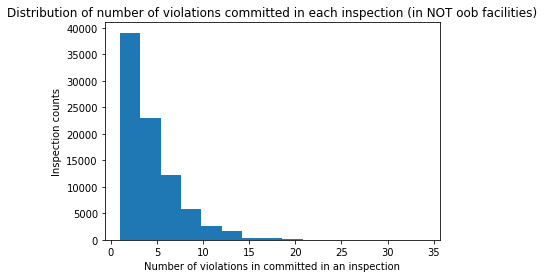

In [607]:
plt.hist(num_vio_not_oob, bins=15)
plt.title('Distribution of number of violations committed in each inspection (in NOT oob facilities)')
plt.xlabel('Number of violations in committed in an inspection')
plt.ylabel('Inspection counts')
plt.show()

In [608]:
print('Average number of violations committed in each inspection (not OOB): ' + str(np.mean(num_vio_not_oob)))
print('Median number of violations committed in each inspection (not OOB): ' + str(np.median(num_vio_not_oob)))

Average number of violations committed in each inspection (not OOB): 4.416111234757348
Median number of violations committed in each inspection (not OOB): 4.0


We observe that the average number of violations committed in each inspection in facilities that went out of business is slightly higher than those that have not gone out of business. 

### **Distribution of total number of violations facilities commit before going out of business**

In [609]:
dup_oob['Violations'].update(violation_nums_oob['Violations'])
dup_oob['Number of Violations'] = dup_oob.Violations.apply(lambda x: len(x)) # create num of violations column
dup_oob.head(10)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Latitude,Longitude,DBA Name,Inspection ID,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Location,Regions,Number of Violations
0,41.644670,-87.540095,BURGER KING,2240219,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-11-15T00:00:00.000,COMPLAINT,Pass w/ Conditions,"[2, 3, 5]","{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH,3
1,41.644670,-87.540095,BURGER KING,2200946,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-08-14T00:00:00.000,COMPLAINT,Pass w/ Conditions,"[2, 3, 5, 49, 55]","{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH,5
2,41.644670,-87.540095,BURGER KING,1950282,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2016-08-12T00:00:00.000,CANVASS,Pass,"[34, 35, 38]","{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH,3
3,41.644670,-87.540095,BURGER KING,1523175,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2015-02-23T00:00:00.000,LICENSE,Pass,"[33, 34, 45]","{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH,3
6,41.644670,-87.540095,BURGER KING,1493718,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2014-08-18T00:00:00.000,CANVASS,Fail,"[8, 21, 33, 34, 35, 36, 38]","{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH,7
7,41.644670,-87.540095,BURGER KING,1300984,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2012-12-19T00:00:00.000,CANVASS,Pass w/ Conditions,"[33, 34, 35, 36, 38]","{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH,5
8,41.644670,-87.540095,BURGER KING,537818,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2012-01-10T00:00:00.000,COMPLAINT,Pass w/ Conditions,"[3, 12, 21, 33, 34]","{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH,5
9,41.644670,-87.540095,BURGER KING,537384,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2011-05-26T00:00:00.000,COMPLAINT,Pass,"[33, 34, 35]","{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH,3
10,41.644670,-87.540095,BURGER KING,419402,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2010-10-12T00:00:00.000,COMPLAINT,Pass w/ Conditions,"[18, 33, 34, 35, 38, 70]","{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH,6
14,41.646371,-87.560342,WINJAMMER MARINA,1395212,WINJAMMER MARINA,79113.0,RESTAURANT,2,13701 S HOXIE AVE,60633.0,2013-12-30T00:00:00.000,CANVASS,Pass,"[14, 18, 34, 35, 36]","{'latitude': '-87.56034196262158', 'longitude'...",HEGEWISCH,5


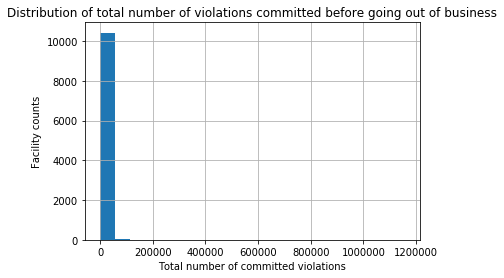

In [610]:
sum_vios = dup_oob.groupby(['DBA Name', 'Latitude', 'Longitude'])['Number of Violations'].sum()
sum_vios.hist(bins=20)
plt.title('Distribution of total number of violations committed before going out of business')
plt.xlabel('Total number of committed violations')
plt.ylabel('Facility counts')
plt.show()

### **Average risk of oob facilities vs. Average risk of NOT oob facilities**

In [611]:
# Average risk of out of business facilities
merged_oob['Risk'].mean()

1.307275706180406

In [612]:
# Average risk of NOT out of business facilities
set_diff_oob['Risk'].mean()  

1.2918272440815752

### **Region vs. Risk Score**

In [613]:
df_region = df.groupby('Regions')['Risk'].mean()
df_region.to_frame().nsmallest(10, 'Risk')

,Risk
Regions,
BURNSIDE,1.000000
OAKLAND,1.166667
NORWOOD PARK,1.203680
EDISON PARK,1.206951
ARMOUR SQUARE,1.216065
NEAR NORTH SIDE,1.229239
LINCOLN PARK,1.233531
PORTAGE PARK,1.245959
NORTH CENTER,1.249224


In [614]:
df_region.to_frame().nlargest(10, 'Risk')

,Risk
Regions,
WEST GARFIELD PARK,1.785241
WEST ENGLEWOOD,1.636305
ENGLEWOOD,1.633903
GREATER GRAND CROSSING,1.602637
WOODLAWN,1.594313
NORTH LAWNDALE,1.581455
AUBURN GRESHAM,1.573504
EAST GARFIELD PARK,1.566380
WEST PULLMAN,1.566185


In [0]:
# TODO: combine this with the percentage(?) of OOB, average # violations, and then rank
# TODO: run knn (or any unsupervised classification) algorithm to cluster neighborhoods, see if it clustered into meaningful clusters

In [0]:
df_region_fac = df.groupby(['Regions', 'Facility Type'])['Risk'].mean()

### **Violation Type Numbers and Their Description**

Violations numbered 1-44 and 70.

Violation #1-14: critical

Violation #15-29: serious 

In [695]:
df_nan_removed_vio = df.dropna(subset=['Violations'])
dict_vio = {}

for j in df_nan_removed_vio['Violations']:
  vio_list = j.split(" | ")
  for i in vio_list:
    result = i[i.find("[0-9]+[. ]")+1 : i.find(" - Comments")]
    vio_pair = result.split(".")
    if(vio_pair[0] not in dict_vio):
      dict_vio[vio_pair[0]] = vio_pair[1]

print(len(dict_vio)) 

dict_vio_sorted = {int(k):v for k,v in dict_vio.items()}
print(sorted(dict_vio_sorted))

pd.set_option('display.max_colwidth', -1) #to display the whole descriptions
vio_descr = pd.DataFrame(list(dict_vio_sorted.items())).rename(columns={0:'Violation Number', 1:'Description'}).sort_values(by=['Violation Number']).set_index('Violation Number')
vio_descr.head(50)

64
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 70]


,Description
Violation Number,
1,"PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLEDGE, AND PERFORMS DUTIES"
2,CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE
3,"MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING"
4,PROPER USE OF RESTRICTION AND EXCLUSIO
5,PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS
6,"PROPER EATING, TASTING, DRINKING, OR TOBACCO USE"
7,"NO DISCHARGE FROM EYES, NOSE, AND MOUT"
8,HANDS CLEAN & PROPERLY WASHED
9,NO BARE HAND CONTACT WITH RTE FOOD OR A PRE-APPROVED ALTERNATIVE PROCEDURE PROPERLY ALLOWED


In [618]:
print(len(vio_descr))

64


In [619]:
merged_oob # facilities that have gone oob
set_diff_oob # facilities that haven't gone oob
critical_vios = list(range(15))
serious_vios = list(range(15, 30))
merged_oob.head()

,Latitude,Longitude,DBA Name,Inspection ID,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Location,Regions
0,41.64467,-87.540095,BURGER KING,2240219,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-11-15T00:00:00.000,COMPLAINT,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
1,41.64467,-87.540095,BURGER KING,2200946,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-08-14T00:00:00.000,COMPLAINT,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
2,41.64467,-87.540095,BURGER KING,1950282,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2016-08-12T00:00:00.000,CANVASS,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...","{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
3,41.64467,-87.540095,BURGER KING,1523175,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2015-02-23T00:00:00.000,LICENSE,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH
6,41.64467,-87.540095,BURGER KING,1493718,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2014-08-18T00:00:00.000,CANVASS,Fail,12. HAND WASHING FACILITIES: WITH SOAP AND SAN...,"{'latitude': '-87.5400946053766', 'longitude':...",HEGEWISCH


In [0]:
merged_oob.dropna(subset=['Violations'], inplace=True)
merged_oob['Violations'] = merged_oob['Violations'].apply(lambda x: re.findall(r'^[0-9]+[.] | [|] [0-9]+[.] ', x))
merged_oob['Violations'] = merged_oob['Violations'].apply(lambda x: [int(sub.replace('|','').split('.')[0]) for sub in x])
merged_oob['Violations'] = merged_oob['Violations'].apply(lambda x: [x for x in x if x in critical_vios + serious_vios])

In [0]:
vio_crit_serious_oob = pd.DataFrame(merged_oob)
vio_crit_serious_oob.reset_index(inplace=True)
vio_crit_serious_oob.drop(columns='index', inplace=True)

vio_freq_crit_serious_oob = {}
for i in vio_crit_serious_oob['Violations']:
  for j in i:
    vio_freq_crit_serious_oob[str(j)] = 1 if str(j) not in vio_freq_crit_serious_oob else vio_freq_crit_serious_oob[str(j)]+1

sorted_vio_freq_crit_serious_oob = {}

for key in sorted(vio_freq_crit_serious_oob, key=vio_freq_crit_serious_oob.__getitem__, reverse=True):
  sorted_vio_freq_crit_serious_oob[key] = vio_freq_crit_serious_oob[key]

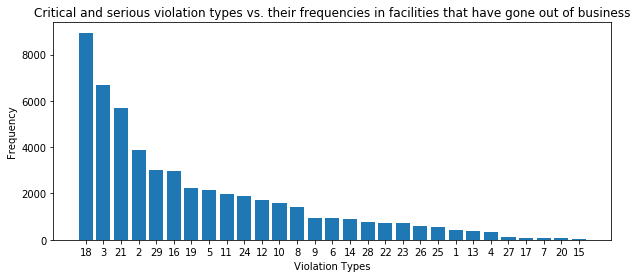

In [646]:
plt.figure(figsize=(10,4))
plt.bar(list(sorted_vio_freq_crit_serious_oob.keys()), sorted_vio_freq_crit_serious_oob.values())
plt.title('Critical and serious violation types vs. their frequencies in facilities that have gone out of business')
plt.xlabel('Violation Types')
plt.ylabel('Frequency')
plt.show()

In [0]:
set_diff_oob.dropna(subset=['Violations'], inplace=True)
set_diff_oob['Violations'] = set_diff_oob['Violations'].apply(lambda x: re.findall(r'^[0-9]+[.] | [|] [0-9]+[.] ', x))
set_diff_oob['Violations'] = set_diff_oob['Violations'].apply(lambda x: [int(sub.replace('|','').split('.')[0]) for sub in x])
set_diff_oob['Violations'] = set_diff_oob['Violations'].apply(lambda x: list(set([x for x in x if x in critical_vios + serious_vios])))

In [0]:
vio_crit_serious_not_oob = pd.DataFrame(set_diff_oob)
vio_crit_serious_not_oob.reset_index(inplace=True)
vio_crit_serious_not_oob.drop(columns='index', inplace=True)

vio_freq_crit_serious_not_oob = {}
for i in vio_crit_serious_not_oob['Violations']:
  for j in i:
    vio_freq_crit_serious_not_oob[str(j)] = 1 if str(j) not in vio_freq_crit_serious_not_oob else vio_freq_crit_serious_not_oob[str(j)]+1

sorted_vio_freq_crit_serious_not_oob = {}

for key in sorted(vio_freq_crit_serious_not_oob, key=vio_freq_crit_serious_not_oob.__getitem__, reverse=True):
  sorted_vio_freq_crit_serious_not_oob[key] = vio_freq_crit_serious_not_oob[key]

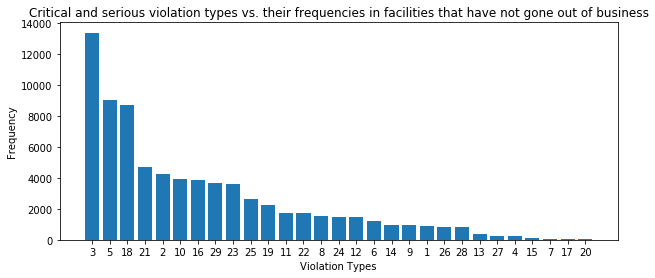

In [647]:
plt.figure(figsize=(10,4))
plt.bar(list(sorted_vio_freq_crit_serious_not_oob.keys()), sorted_vio_freq_crit_serious_not_oob.values())
plt.title('Critical and serious violation types vs. their frequencies in facilities that have not gone out of business')
plt.xlabel('Violation Types')
plt.ylabel('Frequency')
plt.show()

In [0]:
most_freq_crit_serious_oob_15 = [key for key, value in list(sorted_vio_freq_crit_serious_oob.items())[0:15]]
most_freq_crit_serious_oob_10 = [key for key, value in list(sorted_vio_freq_crit_serious_oob.items())[0:10]]
most_freq_crit_serious_oob_5 = [key for key, value in list(sorted_vio_freq_crit_serious_oob.items())[0:5]]
# top 10 and 5 most frequent violation types among facilities that went out of business

In [0]:
most_freq_crit_serious_not_oob_15 = [key for key, value in list(sorted_vio_freq_crit_serious_not_oob.items())[0:15]]
most_freq_crit_serious_not_oob_10 = [key for key, value in list(sorted_vio_freq_crit_serious_not_oob.items())[0:10]]
most_freq_crit_serious_not_oob_5 = [key for key, value in list(sorted_vio_freq_crit_serious_not_oob.items())[0:5]]
# top 15, 10, and 5 most frequent violation types among facilities that didn't go out of business

In [684]:
# The difference of top 5 most frequent critical and serious violation types between oob and not oob facilities
crit_serious_diff_5 = list(set(most_freq_crit_serious_oob_5) - set(most_freq_crit_serious_not_oob_5))
crit_serious_diff_5

['29']

Violation number 29 might be an important factor in making facilities go out of business. So we check its description: 

29 - COMPLIANCE WITH VARIANCE/SPECIALIZED PROCESS/HACCP.

In [686]:
# The difference of top 10 most frequent critical and serious violation types between oob and not oob facilities
crit_serious_diff_10 = list(set(most_freq_crit_serious_oob_10) - set(most_freq_crit_serious_not_oob_10))
crit_serious_diff_10

['24', '11', '19']

Violation number 24, 11, and 19 might be important factors in making facilities go out of business. So we check their descriptions: 

24 - TIME AS A PUBLIC HEALTH CONTROL; PROCEDURES & RECORDS

11 - FOOD OBTAINED FROM APPROVED SOURCE

19 - PROPER REHEATING PROCEDURES FOR HOT HOLDING

In [687]:
# The difference of top 15 most frequent critical and serious violation types between oob and not oob facilities
crit_serious_diff_15 = list(set(most_freq_crit_serious_oob_15) - set(most_freq_crit_serious_not_oob_15))
crit_serious_diff_15

['6', '12', '9']

In [0]:
vio_freq_all = {}
for i in violation_nums_oob['Violations']:
  for j in i:
    vio_freq_oob[str(j)] = 1 if str(j) not in vio_freq_oob else vio_freq_oob[str(j)]+1

### **Region vs. Number/Percentage of OOB**

### **Average number of violations of each facility type (OOB)**


### **Average number of violations of each facility type (not OOB)**


### **Average number of each violation type facilities commit before going out of business**

### **Average number of total violations facilities commit before going out of business**  

## **Our plan for the future:**



- Analyze neighborhoods, taking a deep look into the locations of the facilities, and plotting the neighborhoods on the map (adding the region names on the map)
- Look for hidden reasons why facilities go out of business, taking NLP approaches to process and find out the most frequent violation types
- The trends (risk, violation types, pass/fail results, etc.) facilities follow until they go out of business
- Look for the #1 violation type of the neighborhood
- Prepare poster presentation